In [88]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("liusiyang/eeyore_profile")

In [89]:

import re
import pandas as pd



In [157]:
#@title Define Disfluency and Linguistic Markers

DISFLUENCIES = [
    # Core fillers - SAFE (rarely have other meanings)
    "uh", "um", "umm", "erm", "hmm", "mm", "ah", "ahh", "eh", "ehh",
    "uh huh", "mm hmm", "mhm",

    # Discourse filler - SAFE
    "you know",  # almost always filler in conversation
    "i mean",    # almost always self-repair marker

    # Emotional/paralinguistic markers - SAFE
    "[sigh]", "[deep breath]", "[crying]", "[sniff]", "[pause]",
    "[laughs]", "[clears throat]",
]

LINGUISTIC_MARKERS = {
    # Self-focus
    "i": r"\bi\b",
    "me": r"\bme\b",
    "my": r"\bmy\b",
    "myself": r"\bmyself\b",

    # Social/connection
    "we": r"\bwe\b",
    "us": r"\bus\b",
    "our": r"\bour\b",

    # Absolutist thinking
    "always": r"\balways\b",
    "never": r"\bnever\b",
    "all_or_nothing": r"\b(always|never|nothing|everything)\b",
    "universal_negative": r"\b(no one|everyone|nobody|anybody)\b",

    # Cognitive distortions
    "should": r"\bshould\b",
    "must": r"\bmust\b",
    "cant": r"\bcan't\b|\bcannot\b",
    "blame_words": r"\b(fault|blame)\b",

    # Negative emotion words
    "negative_feelings": r"\b(sad|hopeless|tired|anxious|scared|empty|worthless)\b",

    # Uncertainty/helplessness
    "uncertainty": r"\b(maybe|i think|i guess|possibly|not sure)\b",
    "helplessness": r"\b(i can't|i don't know|can't handle)\b",

    # Rumination markers
    "rumination": r"\b(again|keep thinking|stuck|can't stop)\b",

    # Self-deprecation/inadequacy
    "self_inadequacy": r"\b(should have|not enough|never enough|not worth)\b",

    # Existing extreme emotional words
    "extreme_words": r"\b(terrible|worthless|hopeless|awful|failure)\b",
}


In [158]:
#@title Setup: imports, markers, helpers
# ---- COUNT FUNCTIONS ----
def count_disfluencies(text):
    t = text.lower()
    return sum(t.count(d) for d in DISFLUENCIES)

def count_disfluencies_detailed(text: str) -> dict:
    t = text.lower()
    counts = {d: t.count(d) for d in DISFLUENCIES}
    return counts

def count_markers(text):
    t = text.lower()
    return {m: len(re.findall(pattern, t)) for m, pattern in LINGUISTIC_MARKERS.items()}

def extract_patient_turns_real(esconv_json):
    """Real ESConv format: speaker == 'seeker'"""
    return [turn["content"] for turn in esconv_json["dialog"]
            if turn["speaker"] == "seeker" and turn["content"].strip()]

def extract_patient_turns_synthetic(session_json):
    """Synthetic format: role == 'assistant'"""
    return [msg["content"] for msg in session_json["messages"]
            if msg["role"] == "assistant" and msg["content"].strip()]

#1. Load synthetic sessions

In [94]:
import os

In [98]:
anomi_syn_folder  = "/content/drive/MyDrive/synthetic_convo/patient_psi_annomi"
hope_syn_folder  = "/content/drive/MyDrive/synthetic_convo/patient_psi_hope"
esc_syn_folder  = "/content/drive/MyDrive/synthetic_convo/patient_psi_esc"


In [99]:
import os

syn_folders = [
    anomi_syn_folder,
    esc_syn_folder,
    hope_syn_folder,
]

syn_files = []

for folder in syn_folders:
    syn_files.extend([
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.startswith("session_") and f.endswith(".json")
    ])

syn_files = sorted(syn_files)


In [100]:
syn_files

['/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1008.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1049.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1077.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_108.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1083.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1084.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1133.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1143.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1160.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1162.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1172.json',
 '/content/drive/MyDrive/synthetic_convo/patient_psi_annomi/session_1186.json',
 '/content/drive/MyDrive/synthetic_convo/

#2. Compute per-pair stats (real vs synthetic) - Conversations

In [144]:
import json

In [143]:
real_ds = ds["train"]
def extract_patient_turns_real_eeyore(example):
    # assistant = depressed redditor / patient
    return [
        m["content"]
        for m in example["messages"]
        if m["role"] == "assistant" and m["content"].strip()
    ]


In [138]:
#@title Build Results DataFrame (Disfluency + Linguistic Markers)

import json
from collections import defaultdict

results = []
MAX_CONVERSATIONS = 10000
for syn_path in syn_files:
    if len(results) >= MAX_CONVERSATIONS:
        break
    # --- extract index N from "session_N.json" ---
    fname = os.path.basename(syn_path)           # e.g. "session_3.json"
    idx_str = fname.replace("session_", "").replace(".json", "")
    idx = int(idx_str)

    real_example = real_ds[idx]

    # Load synthetic JSON
    with open(syn_path, "r") as f:
        syn_json = json.load(f)

    # Get patient turns
    real_turns = extract_patient_turns_real_eeyore(real_example)
    syn_turns  = extract_patient_turns_synthetic(syn_json)

    # Disfluency totals
    real_dis_total = sum(count_disfluencies(t) for t in real_turns)
    syn_dis_total  = sum(count_disfluencies(t) for t in syn_turns)

    # Detailed disfluency counts by type
    real_dis_detailed = defaultdict(int)
    for t in real_turns:
        c = count_disfluencies_detailed(t)
        for k in c:
            real_dis_detailed[k] += c[k]

    syn_dis_detailed = defaultdict(int)
    for t in syn_turns:
        c = count_disfluencies_detailed(t)
        for k in c:
            syn_dis_detailed[k] += c[k]

    # Marker totals (per convo)
    real_mark_total = {k: 0 for k in LINGUISTIC_MARKERS.keys()}
    syn_mark_total  = {k: 0 for k in LINGUISTIC_MARKERS.keys()}

    for t in real_turns:
        c = count_markers(t)
        for k in c:
            real_mark_total[k] += c[k]

    for t in syn_turns:
        c = count_markers(t)
        for k in c:
            syn_mark_total[k] += c[k]

    # Conversation length (tokens = whitespace splits)
    real_tokens = sum(len(t.split()) for t in real_turns)
    syn_tokens  = sum(len(t.split()) for t in syn_turns)

    real_dis_norm = real_dis_total / max(real_tokens, 1)
    syn_dis_norm  = syn_dis_total  / max(syn_tokens, 1)

    results.append({
        "session_file": syn_path,
        "session_idx": idx,
        "real_dis": real_dis_total,
        "syn_dis": syn_dis_total,
        "diff_dis": real_dis_total - syn_dis_total,
        "real_tokens": real_tokens,
        "syn_tokens": syn_tokens,
        "real_dis_norm": real_dis_norm,
        "syn_dis_norm": syn_dis_norm,
        "diff_norm": real_dis_norm - syn_dis_norm,
        "real_markers": real_mark_total,
        "syn_markers": syn_mark_total,
        "real_disfluencies_detailed": dict(real_dis_detailed),
        "syn_disfluencies_detailed": dict(syn_dis_detailed),
    })

df = pd.DataFrame(results)
df

,session_file,session_idx,real_dis,syn_dis,diff_dis,real_tokens,syn_tokens,real_dis_norm,syn_dis_norm,diff_norm,real_markers,syn_markers
0,/content/drive/MyDrive/synthetic_convo/patient...,1008,7,5,2,145,1309,0.048276,0.003820,0.044456,"{'i': 23, 'me': 2, 'my': 1, 'myself': 0, 'we':...","{'i': 88, 'me': 21, 'my': 24, 'myself': 5, 'we..."
1,/content/drive/MyDrive/synthetic_convo/patient...,1049,10,11,-1,540,1352,0.018519,0.008136,0.010382,"{'i': 45, 'me': 15, 'my': 0, 'myself': 2, 'we'...","{'i': 102, 'me': 11, 'my': 28, 'myself': 8, 'w..."
2,/content/drive/MyDrive/synthetic_convo/patient...,1077,39,11,28,485,1349,0.080412,0.008154,0.072258,"{'i': 68, 'me': 8, 'my': 12, 'myself': 0, 'we'...","{'i': 108, 'me': 12, 'my': 14, 'myself': 6, 'w..."
3,/content/drive/MyDrive/synthetic_convo/patient...,108,33,10,23,523,1109,0.063098,0.009017,0.054080,"{'i': 49, 'me': 1, 'my': 5, 'myself': 0, 'we':...","{'i': 73, 'me': 3, 'my': 32, 'myself': 4, 'we'..."
4,/content/drive/MyDrive/synthetic_convo/patient...,1083,37,8,29,354,1172,0.104520,0.006826,0.097694,"{'i': 42, 'me': 1, 'my': 7, 'myself': 2, 'we':...","{'i': 117, 'me': 3, 'my': 20, 'myself': 12, 'w..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1392,/content/drive/MyDrive/synthetic_convo/patient...,983,2,14,-12,280,1377,0.007143,0.010167,-0.003024,"{'i': 22, 'me': 1, 'my': 4, 'myself': 0, 'we':...","{'i': 107, 'me': 13, 'my': 17, 'myself': 13, '..."
1393,/content/drive/MyDrive/synthetic_convo/patient...,984,37,2,35,617,1546,0.059968,0.001294,0.058674,"{'i': 49, 'me': 9, 'my': 13, 'myself': 2, 'we'...","{'i': 113, 'me': 10, 'my': 40, 'myself': 13, '..."
1394,/content/drive/MyDrive/synthetic_convo/patient...,988,6,23,-17,253,1341,0.023715,0.017151,0.006564,"{'i': 14, 'me': 1, 'my': 1, 'myself': 0, 'we':...","{'i': 89, 'me': 5, 'my': 29, 'myself': 5, 'we'..."
1395,/content/drive/MyDrive/synthetic_convo/patient...,989,48,5,43,812,866,0.059113,0.005774,0.053340,"{'i': 55, 'me': 10, 'my': 11, 'myself': 0, 'we...","{'i': 77, 'me': 2, 'my': 18, 'myself': 6, 'we'..."


In [163]:
#@title Normalized Disfluency Rates
aggregate_real_norm = df["real_dis_norm"].mean()
aggregate_syn_norm  = df["syn_dis_norm"].mean()
aggregate_diff_norm = df["diff_norm"].mean()

print("=== Aggregate Normalized Disfluency ===")
print("Real (avg per token):      ", aggregate_real_norm)
print("Synthetic (avg per token): ", aggregate_syn_norm)
print("Difference (real - syn):   ", aggregate_diff_norm)


=== Aggregate Normalized Disfluency ===
Real (avg per token):       0.022887907242499787
Synthetic (avg per token):  0.006235099692729899
Difference (real - syn):    0.016652807549769888


In [164]:
#@title  Normalized LinguisticMarker Rates
# --- total tokens across all conversations ---
total_real_tokens = df["real_tokens"].sum()
total_syn_tokens  = df["syn_tokens"].sum()

# --- total marker counts across all marker categories ---
total_real_marker_count = sum(total_real_markers.values())
total_syn_marker_count  = sum(total_syn_markers.values())

# --- per-token normalized marker rates ---
real_marker_norm = total_real_marker_count / max(total_real_tokens, 1)
syn_marker_norm  = total_syn_marker_count / max(total_syn_tokens, 1)

marker_norm_diff = real_marker_norm - syn_marker_norm

print("=== Normalized Marker Rates (per token) ===")
print("Real markers per token:      ", real_marker_norm)
print("Synthetic markers per token: ", syn_marker_norm)
print("Difference (real - syn):     ", marker_norm_diff)


=== Normalized Marker Rates (per token) ===
Real markers per token:       0.13543532308606696
Synthetic markers per token:  0.13814102519509538
Difference (real - syn):      -0.0027057021090284294


In [151]:
#@title Total disfluency / marker counts across all convos
total_real_dis = df["real_dis"].sum()
total_syn_dis  = df["syn_dis"].sum()

print("TOTAL real disfluency across all synthetic-linked convos:", total_real_dis)
print("TOTAL synthetic disfluency across all sessions:", total_syn_dis)
print("Difference (real - synthetic):", total_real_dis - total_syn_dis)


TOTAL real disfluency across all synthetic-linked convos: 9648
TOTAL synthetic disfluency across all sessions: 9065
Difference (real - synthetic): 583


In [159]:
#@title Total Linguistic Marker Frequencies Across Conversations


total_real_markers = {k: 0 for k in LINGUISTIC_MARKERS.keys()}
total_syn_markers  = {k: 0 for k in LINGUISTIC_MARKERS.keys()}

for row in results:
    for k in LINGUISTIC_MARKERS.keys():
        total_real_markers[k] += row["real_markers"][k]
        total_syn_markers[k]  += row["syn_markers"][k]

print("TOTAL real markers:", total_real_markers)
print("TOTAL synthetic markers:", total_syn_markers)

# Total count of ALL real markers combined
total_real_marker_count = sum(total_real_markers.values())

# Total count of ALL synthetic markers combined
total_synthetic_marker_count = sum(total_syn_markers.values())

print("Total REAL marker count:", total_real_marker_count)
print("Total SYNTHETIC marker count:", total_synthetic_marker_count)



TOTAL real markers: {'i': 30191, 'me': 3713, 'my': 5829, 'myself': 565, 'we': 1467, 'us': 193, 'our': 269, 'always': 409, 'never': 360, 'all_or_nothing': 1265, 'universal_negative': 333, 'should': 531, 'must': 33, 'cant': 631, 'blame_words': 45, 'negative_feelings': 591, 'uncertainty': 3050, 'helplessness': 995, 'rumination': 422, 'self_inadequacy': 52, 'extreme_words': 99}
TOTAL synthetic markers: {'i': 110224, 'me': 11424, 'my': 26260, 'myself': 9093, 'we': 947, 'us': 192, 'our': 66, 'always': 313, 'never': 558, 'all_or_nothing': 2920, 'universal_negative': 733, 'should': 474, 'must': 61, 'cant': 18, 'blame_words': 64, 'negative_feelings': 2148, 'uncertainty': 27159, 'helplessness': 17, 'rumination': 4756, 'self_inadequacy': 214, 'extreme_words': 937}
Total REAL marker count: 51043
Total SYNTHETIC marker count: 198578


In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


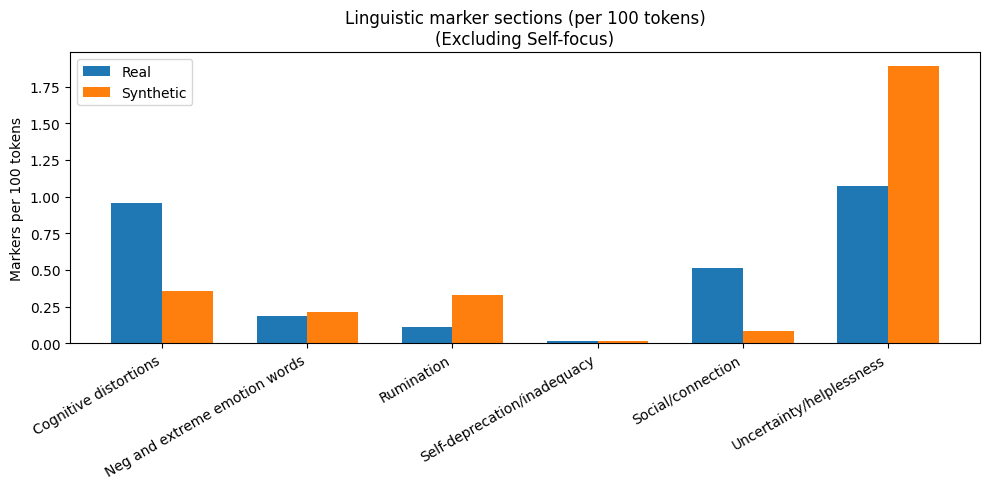

Section-wise normalized rates (markers per 100 tokens):
Cognitive distortions           Real:  0.957   Synthetic:  0.358
Neg and extreme emotion words   Real:  0.183   Synthetic:  0.215
Rumination                      Real:  0.112   Synthetic:  0.331
Self-deprecation/inadequacy     Real:  0.014   Synthetic:  0.015
Social/connection               Real:  0.512   Synthetic:  0.084
Uncertainty/helplessness        Real:  1.073   Synthetic:  1.891


In [161]:
#@title Plot Linguistic marker sections (per 100 tokens) Excluding Self-focus
marker_to_section = {
    # Self-focus
    "i": "Self-focus",
    "me": "Self-focus",
    "my": "Self-focus",
    "myself": "Self-focus",

    # Social/connection
    "we": "Social/connection",
    "us": "Social/connection",
    "our": "Social/connection",

    # Absolutist thinking
    "always": "Cognitive distortions",
    "never": "Cognitive distortions",
    "all_or_nothing": "Cognitive distortions",
    "universal_negative": "Cognitive distortions",

    # Cognitive distortions
    "should": "Cognitive distortions",
    "must": "Cognitive distortions",
    "cant": "Cognitive distortions",
    "blame_words": "Cognitive distortions",

    # Negative emotion words
    "negative_feelings": "Neg and extreme emotion words",

    # Uncertainty/helplessness
    "uncertainty": "Uncertainty/helplessness",
    "helplessness": "Uncertainty/helplessness",

    # Rumination
    "rumination": "Rumination",

    # Self-deprecation/inadequacy
    "self_inadequacy": "Self-deprecation/inadequacy",

    # Extreme emotional words
    "extreme_words": "Neg and extreme emotion words",
}


# ---- 2) Aggregate counts by section ----
section_real_counts = defaultdict(int)
section_syn_counts  = defaultdict(int)

for marker, real_count in total_real_markers.items():
    section = marker_to_section.get(marker, "Other")
    section_real_counts[section] += real_count

for marker, syn_count in total_syn_markers.items():
    section = marker_to_section.get(marker, "Other")
    section_syn_counts[section] += syn_count

# ---- 3) Normalize to proportions (or %) ----
section_real_prop = {}
section_syn_prop  = {}


# --- total tokens across all convos ---
total_real_tokens = df["real_tokens"].sum()
total_syn_tokens  = df["syn_tokens"].sum()

for section in section_real_counts.keys():
    section_real_prop[section] = section_real_counts[section] / total_real_tokens
    section_syn_prop[section]  = section_syn_counts[section]  / total_syn_tokens

# ---- Exclude Self-focus from visualization ----
EXCLUDED_SECTION = "Self-focus"

sections = [
    s for s in sorted(section_real_prop.keys())
    if s != EXCLUDED_SECTION
]

real_vals = [section_real_prop[s] * 100 for s in sections]
syn_vals  = [section_syn_prop[s]  * 100 for s in sections]

# ---- Plot grouped bar chart (normalized) ----
x = range(len(sections))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], real_vals, width=width, label="Real")
plt.bar([i + width/2 for i in x], syn_vals,  width=width, label="Synthetic")

plt.xticks(x, sections, rotation=30, ha="right")
plt.ylabel("Markers per 100 tokens")
plt.title("Linguistic marker sections (per 100 tokens)\n(Excluding Self-focus)")
plt.legend()
plt.tight_layout()
plt.show()


# ---- 5) Optional: print as a nice table ----
print("Section-wise normalized rates (markers per 100 tokens):")
for s, rv, sv in zip(sections, real_vals, syn_vals):
    print(f"{s:30s}  Real: {rv:6.3f}   Synthetic: {sv:6.3f}")


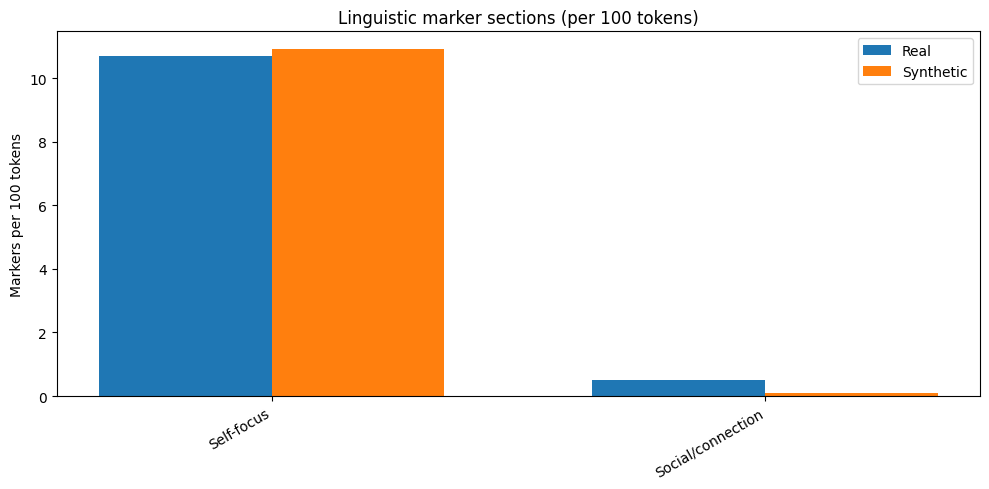

Section-wise normalized rates (markers per 100 tokens):
Self-focus                      Real: 10.692   Synthetic: 10.922
Social/connection               Real:  0.512   Synthetic:  0.084


In [147]:
import matplotlib.pyplot as plt
from collections import defaultdict

#@title Plot Linguistic marker sections (per 100 tokens) for Self Focus, Social Connectons

# You already have these:
# total_real_markers, total_syn_markers, total_real_marker_count, total_synthetic_marker_count

# ---- 2) Aggregate counts by section ----
section_real_counts = defaultdict(int)
section_syn_counts  = defaultdict(int)

for marker, real_count in total_real_markers.items():
    section = marker_to_section.get(marker, "Other")
    section_real_counts[section] += real_count

for marker, syn_count in total_syn_markers.items():
    section = marker_to_section.get(marker, "Other")
    section_syn_counts[section] += syn_count

# ---- 3) Normalize to proportions (or %) ----
section_real_prop = {}
section_syn_prop  = {}

# for section in section_real_counts.keys():
#     section_real_prop[section] = section_real_counts[section] / total_real_marker_count
#     section_syn_prop[section]  = section_syn_counts[section]  / total_synthetic_marker_count

# --- total tokens across all convos ---
total_real_tokens = df["real_tokens"].sum()
total_syn_tokens  = df["syn_tokens"].sum()

for section in section_real_counts.keys():
    section_real_prop[section] = section_real_counts[section] / total_real_tokens
    section_syn_prop[section]  = section_syn_counts[section]  / total_syn_tokens

# ---- Keep ONLY Self-focus and Social/connection ----
KEEP_SECTIONS = {"Self-focus", "Social/connection"}

sections = [
    s for s in sorted(section_real_prop.keys())
    if s in KEEP_SECTIONS
]

real_vals = [section_real_prop[s] * 100 for s in sections]
syn_vals  = [section_syn_prop[s]  * 100 for s in sections]

# ---- Plot grouped bar chart (normalized) ----
x = range(len(sections))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], real_vals, width=width, label="Real")
plt.bar([i + width/2 for i in x], syn_vals,  width=width, label="Synthetic")

plt.xticks(x, sections, rotation=30, ha="right")
plt.ylabel("Markers per 100 tokens")
plt.title("Linguistic marker sections (per 100 tokens)")
plt.legend()
plt.tight_layout()
plt.show()


# ---- 5) Optional: print as a nice table ----
print("Section-wise normalized rates (markers per 100 tokens):")
for s, rv, sv in zip(sections, real_vals, syn_vals):
    print(f"{s:30s}  Real: {rv:6.3f}   Synthetic: {sv:6.3f}")


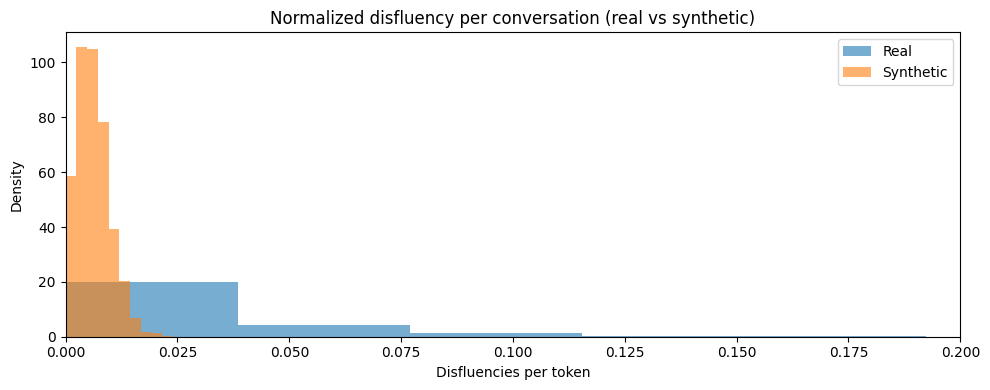

In [152]:
#@title Histogram of disfluency per conversation (real vs synthetic)
plt.figure(figsize=(10,4))

plt.hist(
    df["real_dis_norm"],
    bins=10,
    alpha=0.6,
    label="Real",
    density=True
)

plt.hist(
    df["syn_dis_norm"],
    bins=10,
    alpha=0.6,
    label="Synthetic",
    density=True
)

plt.title("Normalized disfluency per conversation (real vs synthetic)")
plt.xlabel("Disfluencies per token")
plt.ylabel("Density")

plt.xlim(0, 0.20)   # ✅ this is what you want

plt.legend()
plt.tight_layout()
plt.show()


#3. Compute disfluency stats (real vs synthetic) - Per Turn

In [148]:
#@title Per-Turn Normalized Disfluency Computation

import numpy as np
import matplotlib.pyplot as plt

MAX_TURNS = 12

# For each turn index k, we keep a list of disfluency counts across conversations
real_dis_by_turn = [[] for _ in range(MAX_TURNS)]
syn_dis_by_turn  = [[] for _ in range(MAX_TURNS)]

# New lists for token counts and normalized disfluencies per turn
real_tokens_by_turn = [[] for _ in range(MAX_TURNS)]
syn_tokens_by_turn  = [[] for _ in range(MAX_TURNS)]
real_dis_norm_by_turn = [[] for _ in range(MAX_TURNS)]
syn_dis_norm_by_turn  = [[] for _ in range(MAX_TURNS)]

real_turn_counts = []   # number of patient turns in each real convo
syn_turn_counts  = []   # number of patient turns in each synthetic convo
# MAX_CONVERSATIONS = 15
# i = 0
for syn_path in rpd_syn_files:
  # i += 1
  # if i >= MAX_CONVERSATIONS:
  #   break
  # else:
    # ---- get session index N from "session_N.json" ----
  fname = os.path.basename(syn_path)           # e.g. "session_3.json"
  idx_str = fname.replace("session_", "").replace(".json", "")
  idx = int(idx_str)

  # Map session_N.json -> row N in eeyore_profile
  real_example = real_ds[idx]

  # Load synthetic JSON
  with open(syn_path, "r") as f:
      syn_json = json.load(f)

  # Patient turns
  real_turns = extract_patient_turns_real_eeyore(real_example)
  syn_turns  = extract_patient_turns_synthetic(syn_json)

  real_turn_counts.append(len(real_turns))
  syn_turn_counts.append(len(syn_turns))

  # For each turn index up to MAX_TURNS, collect disfluency counts and token counts
  for k in range(MAX_TURNS):
      # real
      if k < len(real_turns):
          real_dis = count_disfluencies(real_turns[k])
          real_turn_tokens = len(real_turns[k].split())
          real_dis_by_turn[k].append(real_dis)
          real_tokens_by_turn[k].append(real_turn_tokens)
          real_dis_norm_by_turn[k].append(real_dis / max(real_turn_tokens, 1))
      # synthetic
      if k < len(syn_turns):
          syn_dis = count_disfluencies(syn_turns[k])
          syn_turn_tokens = len(syn_turns[k].split())
          syn_dis_by_turn[k].append(syn_dis)
          syn_tokens_by_turn[k].append(syn_turn_tokens)
          syn_dis_norm_by_turn[k].append(syn_dis / max(syn_turn_tokens, 1))

In [154]:
#@title Per-Turn Mean Normalized Disfluency Table (Across Conversations)
rows = []
for k in range(MAX_TURNS):
    real_vals = real_dis_by_turn[k]
    syn_vals  = syn_dis_by_turn[k]

    real_norm_vals = real_dis_norm_by_turn[k]
    syn_norm_vals  = syn_dis_norm_by_turn[k]

    if len(real_vals) == 0 and len(syn_vals) == 0:
        continue  # no data for this turn

    row = {
        "turn_index": k + 1,  # 1-based for readability
        # "real_mean_dis": np.mean(real_vals) if real_vals else 0.0,
        # "real_var_dis":  np.var(real_vals, ddof=1) if len(real_vals) > 1 else 0.0,
        "real_n_convos": len(real_vals),

        # "syn_mean_dis": np.mean(syn_vals) if syn_vals else 0.0,
        # "syn_var_dis":  np.var(syn_vals, ddof=1) if len(syn_vals) > 1 else 0.0,
        "syn_n_convos": len(syn_vals),

        "real_mean_dis_norm": np.mean(real_norm_vals) if real_norm_vals else 0.0,
        # "real_var_dis_norm":  np.var(real_norm_vals, ddof=1) if len(real_norm_vals) > 1 else 0.0,

        "syn_mean_dis_norm": np.mean(syn_norm_vals) if syn_norm_vals else 0.0,
        # "syn_var_dis_norm":  np.var(syn_norm_vals, ddof=1) if len(syn_norm_vals) > 1 else 0.0,
    }
    rows.append(row)

per_turn_df = pd.DataFrame(rows)
per_turn_df

,turn_index,real_n_convos,syn_n_convos,real_mean_dis_norm,syn_mean_dis_norm
0,1,1397,1397,0.054619,0.000763
1,2,1397,1397,0.067766,0.005285
2,3,1397,1397,0.069124,0.005507
3,4,1395,1394,0.078961,0.005777
4,5,1394,1389,0.067610,0.005799
5,6,1393,1379,0.078341,0.006104
6,7,1377,1351,0.079607,0.006214
7,8,1364,1303,0.078114,0.006523
8,9,1344,1220,0.072417,0.006604
9,10,1320,1066,0.070952,0.006728


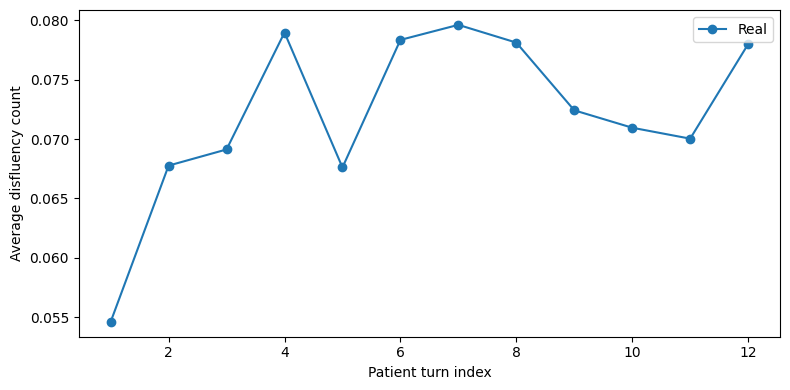

In [155]:
#@title Plot: average disfluency per turn (real)

plt.figure(figsize=(8,4))
plt.plot(per_turn_df["turn_index"], per_turn_df["real_mean_dis_norm"],
         marker="o", label="Real")
# plt.plot(per_turn_df["turn_index"], per_turn_df["syn_mean_dis_norm"],
#          marker="o", label="Synthetic")
plt.xlabel("Patient turn index")
plt.ylabel("Average disfluency count")
# plt.title(f"Average disfluencies per turn (first {MAX_TURNS} turns)")
plt.legend()
plt.tight_layout()
plt.show()

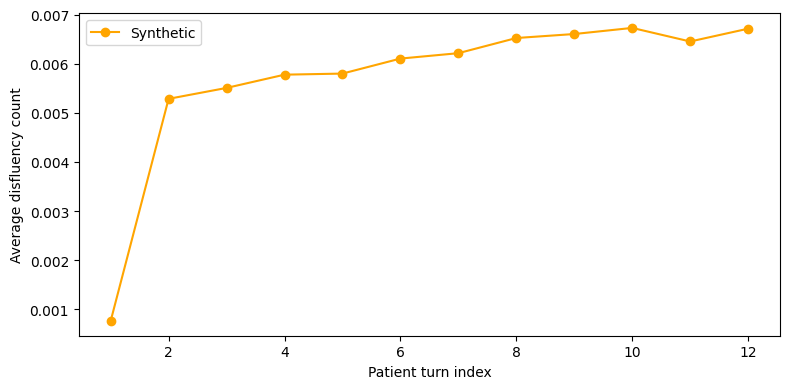

In [156]:
#@title Plot: average disfluency per turn (synthetic)

plt.figure(figsize=(8,4))
plt.plot(per_turn_df["turn_index"], per_turn_df["syn_mean_dis_norm"],
         marker="o", label="Synthetic", color="orange")
plt.xlabel("Patient turn index")
plt.ylabel("Average disfluency count")
# plt.title(f"Average disfluencies per turn (first {MAX_TURNS} turns)")
plt.legend()
plt.tight_layout()
plt.show()